In [ ]:
%run funcs
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
print(device)

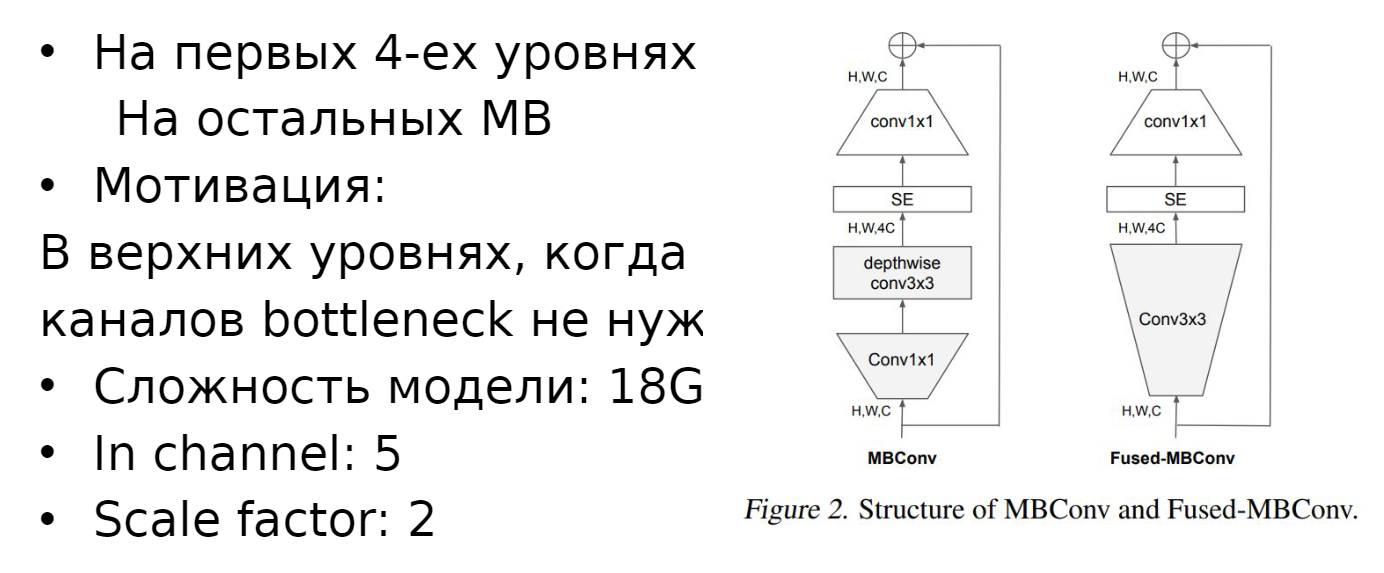

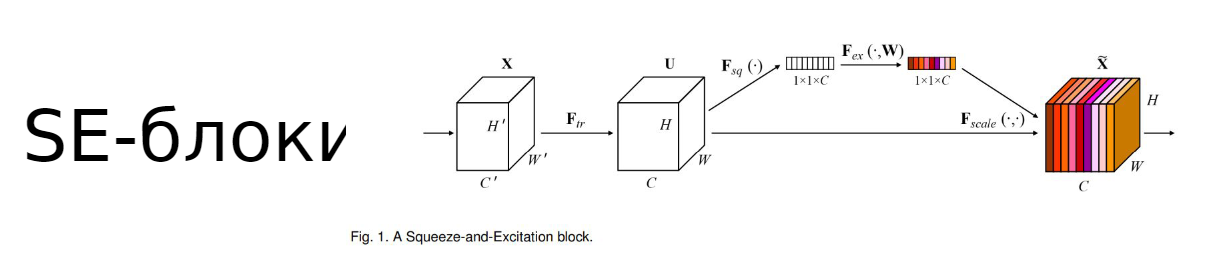

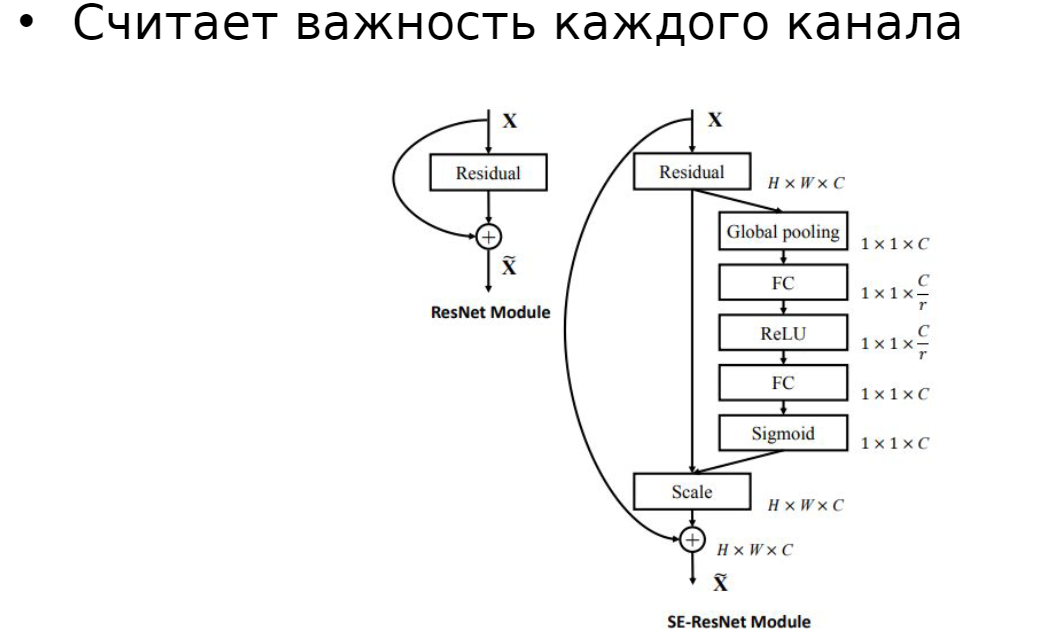

In [ ]:
class Transition_Block(torch.nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.trans_module = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size*2, kernel_size=3, stride=2,padding=1 , bias = False),
            torch.nn.BatchNorm1d(num_features=input_size*2),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
        return  self.trans_module(inputs) 
    
power = 4
bias_mask = False
class SE_Block_power(torch.nn.Module):
    def __init__(self,input_size, group_number):
        super().__init__()
        self.module = torch.nn.Sequential(    
            torch.nn.Conv1d(input_size, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power, input_size*power,  kernel_size=3, stride=1,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size*power),
            torch.nn.PReLU(),
            torch.nn.Conv1d(input_size*power,input_size,  kernel_size=3, stride= 1 ,padding=1,bias = bias_mask,
                           groups = group_number),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.PReLU()
          )
        self.conv = torch.nn.Sequential( 
            torch.nn.Conv1d(input_size, input_size, kernel_size =1,bias =  bias_mask,
                           groups = group_number),
            torch.nn.PReLU()
        )
    def forward(self, inputs):
          return  (self.module(inputs) +self.conv(inputs))
a = torch.ones((512,5 ,32))
net_MC_data = torch.nn.Sequential(    
    torch.nn.Conv1d(5, 5,  kernel_size= 3 , stride = 1 ,padding= 1 ,bias = bias_mask),
    torch.nn.BatchNorm1d(5),
    torch.nn.PReLU(),
    ResNet_Block_power(5, group_number = 5), #32
    ResNet_Block_power(5, group_number = 5), 
    Transition_Block(5), #16
    ResNet_Block_power(10, group_number = 10),
    ResNet_Block_power(10, group_number = 10), #16
    Transition_Block(10), #8
    ResNet_Block_power(20, group_number = 20),
    ResNet_Block_power(20, group_number = 20), 
    Transition_Block(20), #4
    ResNet_Block_power(40, group_number = 40),
    ResNet_Block_power(40, group_number = 40), # 4
    torch.nn.Flatten(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160,160),
    torch.nn.BatchNorm1d(160),
    torch.nn.PReLU(),
    torch.nn.Linear(160 ,2)
) 

print(net_MC_data(a).shape )
sum(p.numel() for p in net_MC_data.parameters()   )